In [1]:
import numpy as np
import py21cmfast as p21c

import matplotlib.pyplot as plt
%matplotlib inline

from py21cmfast import global_params
from py21cmfast import plotting

from vcb_gen import generate_vcb

/home/ram/anaconda3/envs/21cm/lib/python3.8/site-packages/py21cmfast/_cfg.py:57: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/ram/anaconda3/envs/21cm/lib/python3.8/site-packages/py21cmfast/_cfg.py:41: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [2]:
vcb, vcb_wr = generate_vcb(num_cubes=10)

Text(0.5, 0.06, 'Post-Wedge-removal')

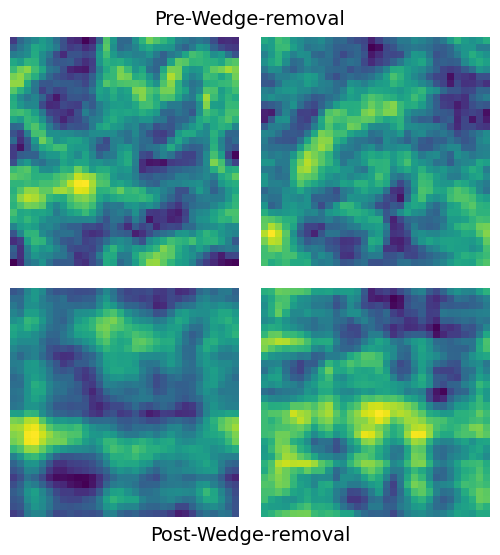

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))

for i in range(2):
    ax[0][i].imshow(vcb[i][0])
    ax[0][i].axis('off')

for i in range(2):
    ax[1][i].imshow(vcb_wr[i][0])
    ax[1][i].axis('off')

fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.1)

fig.text(0.5, 0.92, 'Pre-Wedge-removal', ha='center', fontsize=14, family='sans')
fig.text(0.5, 0.06, 'Post-Wedge-removal', ha='center', fontsize=14, family='sans')

In [4]:
import torch
import torch.nn as nn

In [27]:
class BasicUNet(nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([ 
            nn.Conv3d(in_channels, 4, kernel_size=5, padding=2),
            nn.Conv3d(4, 8, kernel_size=5, padding=2),
            nn.Conv3d(8, 8, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv3d(8, 8, kernel_size=5, padding=2),
            nn.Conv3d(8, 4, kernel_size=5, padding=2),
            nn.Conv3d(4, out_channels, kernel_size=5, padding=2), 
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool3d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer
              
        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function
            
        return x

In [28]:
Model=BasicUNet(in_channels=1, out_channels=1)

In [34]:
X=torch.tensor(np.reshape(vcb_wr, (10, 1, 32, 32, 32)), dtype=torch.float32)
Y=torch.tensor(np.reshape(vcb, (10, 1, 32, 32, 32)), dtype=torch.float32)

X_max=torch.max(X)
X_min=torch.min(X)

Y_max=torch.max(Y)
Y_min=torch.min(Y)

def normalize(T, T_max, T_min):
    a=2.0/(T_max - T_min)
    b=-(T_max + T_min)/(T_max - T_min)
    return a*T + b

X=normalize(X, X_max, X_min)
Y=normalize(Y, Y_max, Y_min)


In [38]:
N_epochs=1000
lr=1.0e-03
eps=0.0
loss=torch.nn.MSELoss()
loss_list=[]

In [ ]:
optimizer = torch.optim.Adam(Model.parameters(), lr=lr, eps=eps)

for epoch in range(1, N_epochs + 1):
    optimizer.zero_grad()
    Y_pred = Model(X)
    loss_val = loss(Y, Y_pred)
    loss_val.backward()
    optimizer.step()
    loss_list.append(loss_val.detach().numpy())
    if epoch % 100 == 0:
        print("%d complete, loss_value = %f" % (epoch, loss_list[-1]), flush=True)

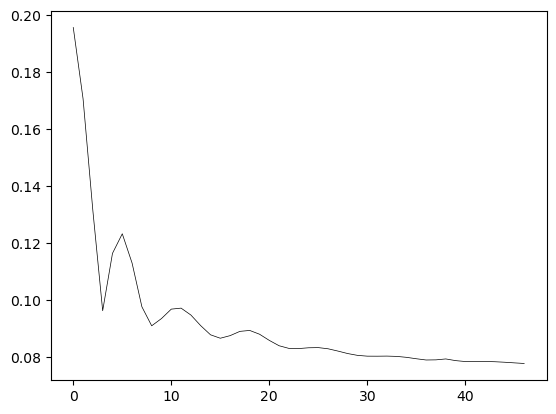

In [43]:
plt.plot(loss_list, ls='-', color='k', lw=0.5)
plt.show()

In [44]:
vcb_pred=np.reshape(Model(X).detach().numpy(), (10, 32, 32, 32))

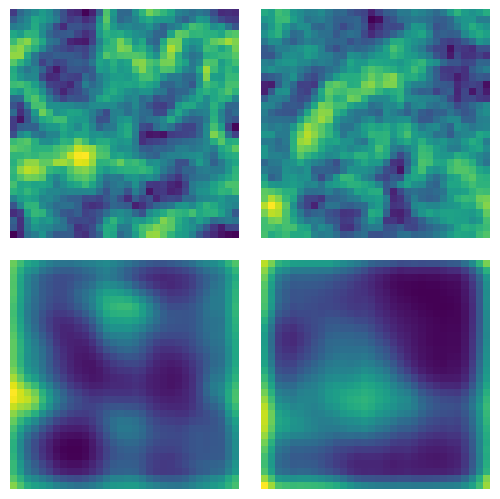

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))

for i in range(2):
    ax[0][i].imshow(vcb[i][0])
    ax[0][i].axis('off')

for i in range(2):
    ax[1][i].imshow(vcb_pred[i][0])
    ax[1][i].axis('off')

fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.1)